# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/7b9e0f9a1f2bde897087d04a02c9406c2c162643aa504e072c087cdf.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Plantation, Florida, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'7b9e0f9a1f2bde897087d04a02c9406c2c162643aa504e072c087cdf')

In [2]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches
from IPython.display import HTML, display

In [3]:
def stringify(i):
    return '0%s' % str(i) if i < 10 else str(i)

In [4]:
# read file and csv
filename = r'data/C2A2_data/BinnedCsvs_d400/7b9e0f9a1f2bde897087d04a02c9406c2c162643aa504e072c087cdf.csv'
df = pd.read_csv(filename)

# convert the C/10 to C
df['Data_Value'] = df['Data_Value'] / 10

# convert Date column to date and create helper "date" column
df['Date'] = pd.to_datetime(df['Date'])
df['m-d'] = df['Date'].dt.strftime('%m-%d')

#drop feb 29s rows
df.drop(df[df['m-d'] == '02-29'].index.tolist(), inplace=True)

# split into pre-2015 and post-2015
before = df[(df['Date'] >= '2005-01-01') & (df['Date'] <= '2014-12-01')]
after = df[df['Date'] >= '2015-01-01']

# create subsets split by mins and maxs
MINS = before[before['Element'] == 'TMIN']
MAXS = before[before['Element'] == 'TMAX']

tmins = MINS.groupby('m-d').agg('min').rename(columns={'Data_Value': 'TMIN'}).drop(['ID', 'Date', 'Element'], axis=1)
tmaxs = MAXS.groupby('m-d').agg('max').rename(columns={'Data_Value': 'TMAX'}).drop(['ID', 'Date', 'Element'], axis=1)

# merge tmins and tmaxs
both = tmins.merge(tmaxs, left_index=True, right_index=True)

# do the same with the "after" dataframe
aMINS = after[after['Element'] == 'TMIN']
aMAXS = after[after['Element'] == 'TMAX']
atmins = aMINS.groupby('m-d').agg('min').rename(columns={'Data_Value': 'TMIN'}).drop(['ID', 'Date', 'Element'], axis=1)
atmaxs = aMAXS.groupby('m-d').agg('max').rename(columns={'Data_Value': 'TMAX'}).drop(['ID', 'Date', 'Element'], axis=1)
aboth = atmins.merge(atmaxs, left_index=True, right_index=True)

# Add the record highs and lows for 2015
both['2015 record low'] = both.apply(
    lambda x: aboth.loc[x.name, 'TMIN'] if aboth.loc[x.name, 'TMIN'] < x['TMIN'] else np.NaN, axis=1 )
both['2015 record high'] = both.apply(
    lambda x: aboth.loc[x.name, 'TMAX'] if aboth.loc[x.name, 'TMAX'] > x['TMAX'] else np.NaN, axis=1 )

keepers = ['%s-01' % stringify(m) for m in range(1, 13)]
x_labels = [i if i in keepers else '' for i in both.index.tolist()]

/home/djangulo/documents/Applied-Data-Science-in-Python/.env/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


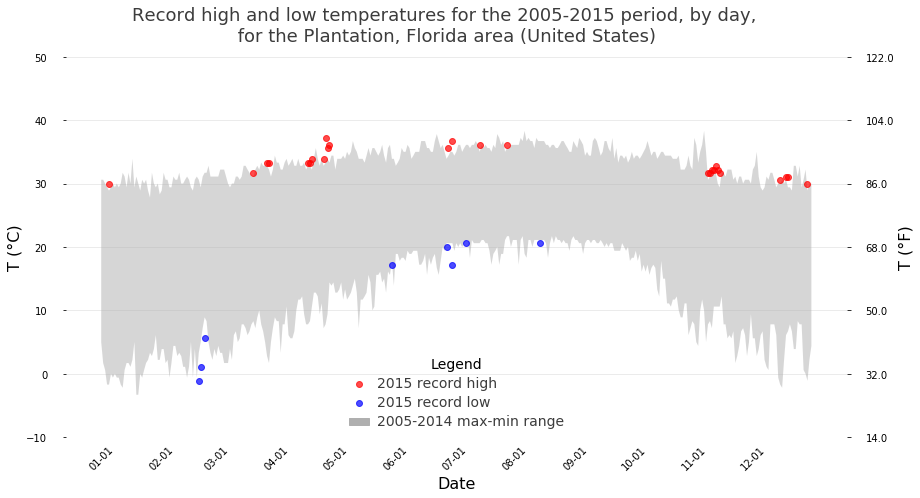

In [5]:
# plot em'
%matplotlib inline
lines = plt.plot(both.loc[:, ['TMIN', 'TMAX']])
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(14, 7, forward=True)
plt.fill_between(both.index, both['TMIN'], both['TMAX'], facecolor='#afafaf', alpha=0.5)
plt.plot(both['2015 record high'], 'o', color='red', alpha=0.7)
plt.plot(both['2015 record low'], 'o', color='blue', alpha=0.7)

plt.legend(loc=8, frameon=False, title='Legend')
plt.tick_params(axis='x', which='both', bottom=None, top=None)

lines[0].set_color((0,0,0,0))
lines[1].set_color((0,0,0,0))
ranges = mpatches.Patch([],[], color='#afafaf', label='2005-2014 max-min range')
handles, labels = ax.get_legend_handles_labels()

handles += [ranges]

legend = plt.legend(handles=handles, loc=8, frameon=False, title='Legend')

for text in legend.get_texts():
    text.set_color('#3c3c3c')
    text.set_fontsize(14)

legend.get_title().set_fontsize(14)

ax.tick_params(axis='y', pad=15)
ax.set_xticklabels(x_labels)
ax.set_yticks(list(ax.get_yticks()))
fig.suptitle('Record high and low temperatures for the 2005-2015 period, by day,\n for the Plantation, Florida area (United States)', color='#3c3c3c', fontsize=18)
plt.ylabel('T (°C)', fontsize=16)
plt.xlabel('Date', fontsize=16)
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(45)

# draw the second axis
y2labels = list(map(lambda x: (x * 1.8) + 32, list(ax.get_yticks())))
ax2 = ax.twinx()
ax2.set_yticks(list(ax.get_yticks()))
ax2.set_yticklabels(y2labels)
ax2.tick_params(pad=15)
ax2.set_ylabel('T (°F)', fontsize=16, rotation='horizontal')
ax2.yaxis.get_label().set_rotation(90)

# remove all spines
for child in ax.get_children():
    if isinstance(child, mpl.spines.Spine):
        child.set_visible(False)
for child in ax2.get_children():
    if isinstance(child, mpl.spines.Spine):
        child.set_visible(False)

ax.grid('on', which='major', axis='y', alpha=0.3)
plt.show()

#save it
fig.savefig('assignment2_denis_angulo.png', bbox_inches='tight')
